In [41]:
import covid_feature_extraction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [3]:
dates, state_y, state_X, feature_labels = covid_feature_extraction.state_extraction("Population")

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [31]:
weekly_dates = []
weekly_covid_cases = []
weekly_travelers = []
for i in range(len(dates)//7):
    sub_cases = state_X["total_cases"][i*7:(i+1)*7]
    sub_travelers = state_y.reset_index(drop=True)[i*7:(i+1)*7]
    week_cases = sub_cases.sum()
    week_travelers = sub_travelers.sum()
    weekly_covid_cases.append(week_cases)
    weekly_travelers.append(week_travelers)
    weekly_dates.append(dates.reset_index(drop=True)[i*7])

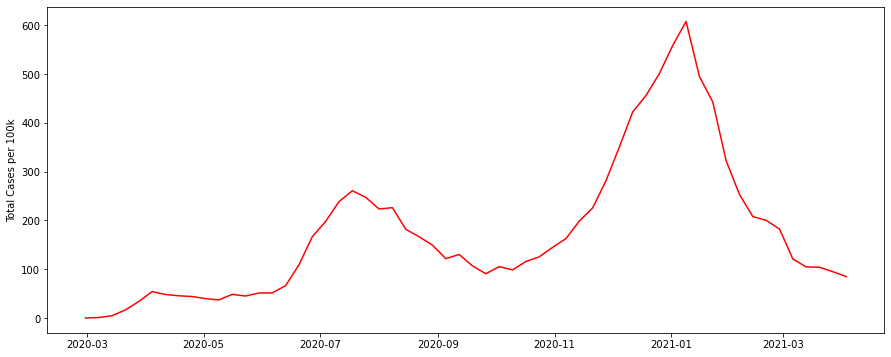

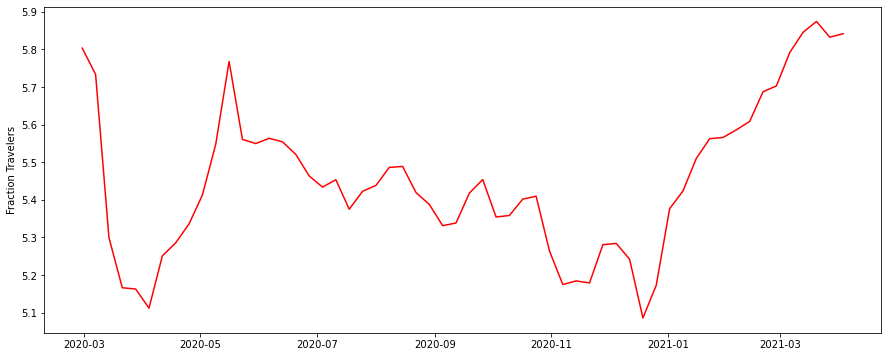

In [32]:
fig = plt.subplots(figsize=(15,6))
plt.plot(weekly_dates, weekly_covid_cases,color='red')
plt.ylabel("Total Cases per 100k")
plt.show()

fig = plt.subplots(figsize=(15,6))
plt.plot(weekly_dates, weekly_travelers,color='red')
plt.ylabel("Fraction Travelers")
plt.show()

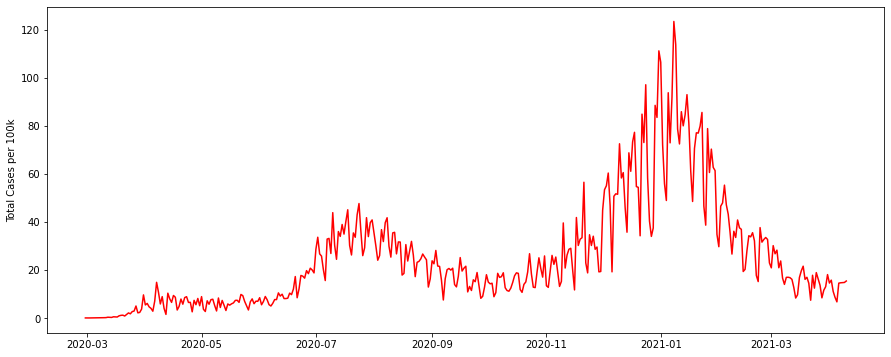

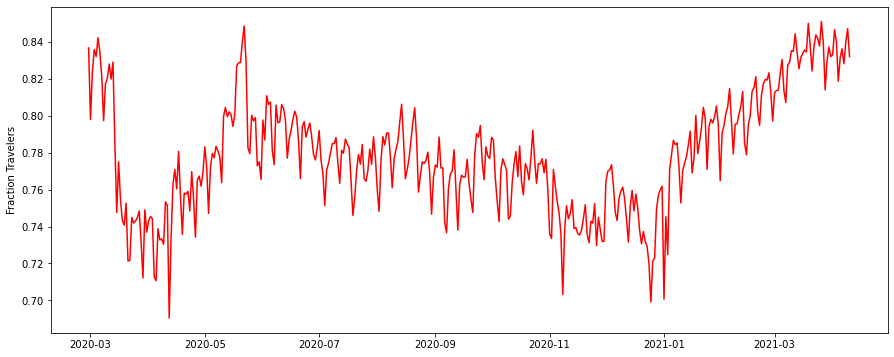

In [8]:
fig = plt.subplots(figsize=(15,6))
plt.plot(dates, state_X["total_cases"],color='red')
plt.ylabel("Total Cases per 100k")
plt.show()

fig = plt.subplots(figsize=(15,6))
plt.plot(dates, state_y,color='red')
plt.ylabel("Fraction Travelers")
plt.show()

In [47]:
# this sees if "total_cases" granger causes state_y
combined_data = pd.concat([state_y.reset_index(drop=True),state_X["total_cases"]],axis=1)
gct = grangercausalitytests(combined_data,maxlag=15,verbose=False)
p_val_dict = {}
for key in gct.keys():
    p_value = gct[key][0]['ssr_ftest'][1]
    p_val_dict[key] = p_value
p_val_dict

{1: 0.01664464515004257,
 2: 0.015711686171860546,
 3: 0.11787050816503103,
 4: 0.013476471064061421,
 5: 0.004784994785203016,
 6: 2.7147360346909922e-11,
 7: 1.7716772569696635e-08,
 8: 2.5189039454051904e-06,
 9: 6.965117083338334e-06,
 10: 1.9436559789961613e-05,
 11: 2.732762878511572e-05,
 12: 5.500653331252342e-05,
 13: 1.2474928551502117e-05,
 14: 4.902961457979399e-06,
 15: 9.424028785329021e-05}

In [45]:
gct[2][0]['ssr_ftest'][1]

0.015711686171860546